<a href="https://colab.research.google.com/github/vimesh630/Spice_Price_Predction_VERGER/blob/Cinnamon/LightBGM_for_Forecastig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Mount Google Drive and Import Libraries

In [9]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm.callback import early_stopping, log_evaluation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Load Data

In [10]:
file_path = "/content/drive/MyDrive/VERGER/Cinnamon_Price_Prediction/Cinnamon_Dataset_Preprocessed.csv"
df = pd.read_csv(file_path)

# Convert Month to datetime
df['Month'] = pd.to_datetime(df['Month'])

# Ensure categorical types
df['Grade'] = df['Grade'].astype('category')
df['Region'] = df['Region'].astype('category')

# Target & features
target = 'Regional_Price'
categorical_features = ['Grade', 'Region']
features = [col for col in df.columns if col not in [target, 'Month']]

#3. Time-Based Split

In [11]:
df = df.sort_values('Month')
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

#4. Train LightBGM

In [12]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(100)]
)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 84.3725	valid_1's rmse: 137.488
Early stopping, best iteration is:
[74]	training's rmse: 98.9098	valid_1's rmse: 135.526


#5. Model Evaluation

In [13]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

RMSE: 135.53
MAE: 102.44
R²: 0.9397


#6. MAPE

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---- 1. Model Evaluation with MAPE ----
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # in %

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 135.53
MAE: 102.44
R²: 0.9397
MAPE: 3.07%


#7. Feature Importance


Top 10 Important Features:
                Feature    Importance
18          price_lag_1  6.600358e+09
3        National_Price  3.380150e+09
19          price_lag_2  6.370245e+07
20          price_lag_3  5.595104e+07
12       Inflation_Rate  2.994412e+07
6   Local_Export_Volume  1.619154e+07
21          price_lag_6  1.365783e+07
11        Exchange_Rate  1.336171e+07
25     price_roll_std_6  1.268687e+07
1                Region  1.193544e+07


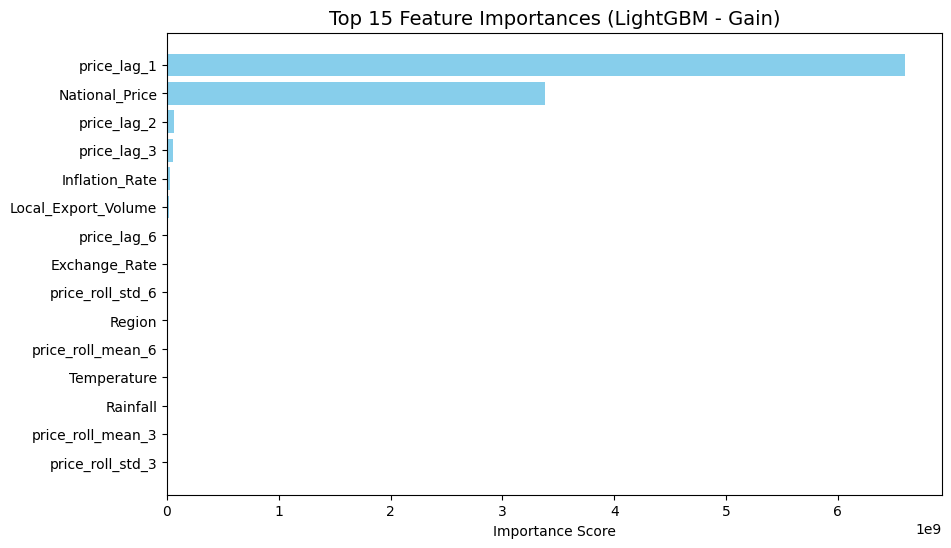

In [16]:
importance = model.feature_importance(importance_type='gain')
feature_names = X_train.columns

# Create dataframe for sorting & visualization
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Important Features:")
print(fi_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(fi_df['Feature'][:15], fi_df['Importance'][:15], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (LightGBM - Gain)", fontsize=14)
plt.xlabel("Importance Score")
plt.show()

#8. Actual vs Predicted

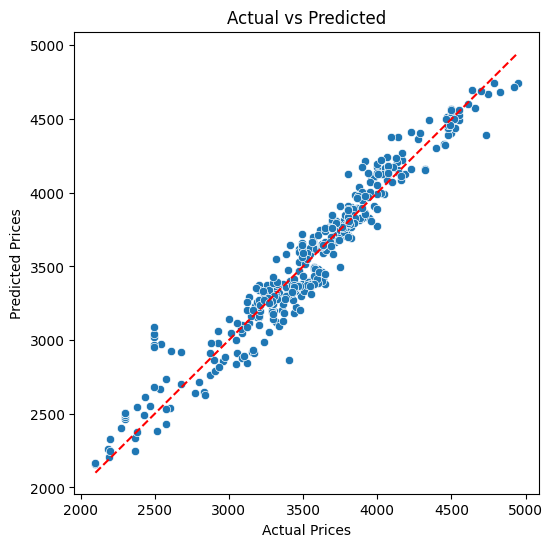

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=model.predict(X_test))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted')
plt.show()

#9. Residuals Distribution

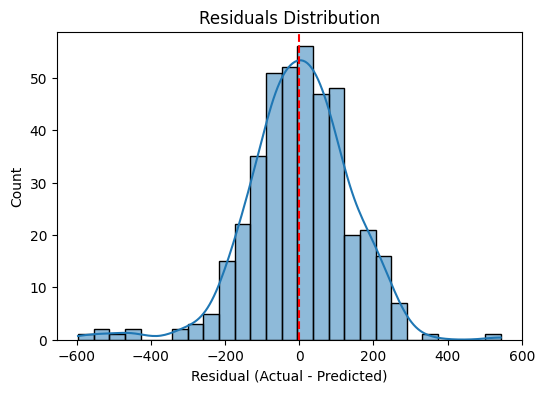

In [19]:
residuals = y_test - model.predict(X_test)
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Residuals Distribution')
plt.show()

#10. Residuals vs Predicted

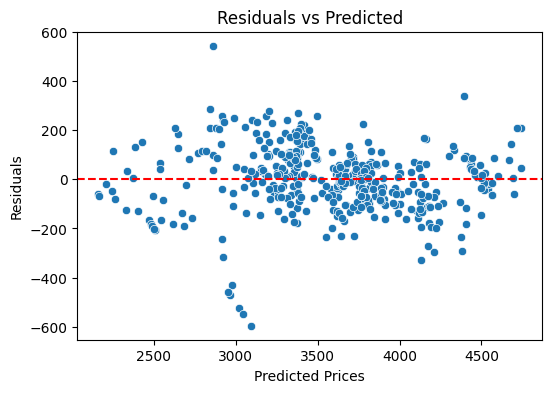

In [20]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=model.predict(X_test), y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

#11. Time Series: Actual vs Predicted

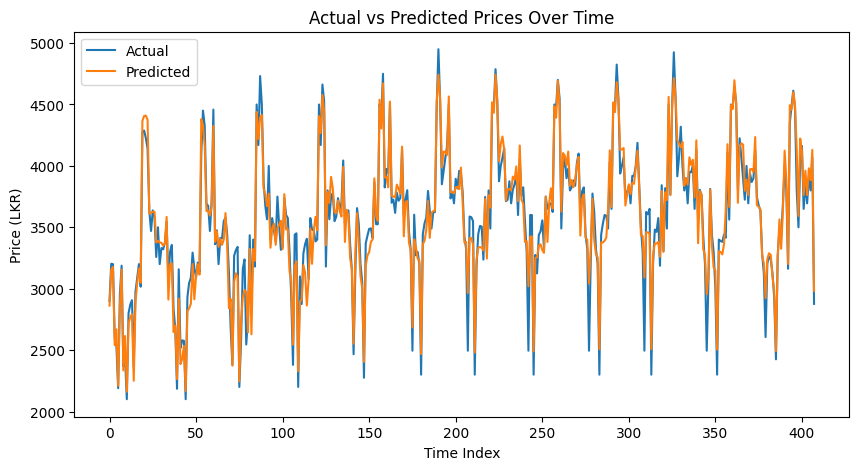

In [21]:
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_test)), model.predict(X_test), label='Predicted')
plt.xlabel('Time Index')
plt.ylabel('Price (LKR)')
plt.title('Actual vs Predicted Prices Over Time')
plt.legend()
plt.show()

#12. Error Over Time

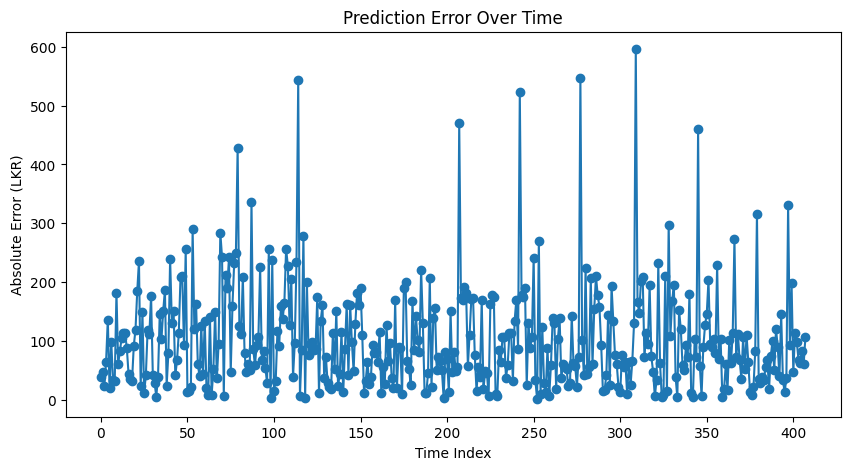

In [22]:
plt.figure(figsize=(10,5))
plt.plot(range(len(residuals)), np.abs(residuals), marker='o')
plt.xlabel('Time Index')
plt.ylabel('Absolute Error (LKR)')
plt.title('Prediction Error Over Time')
plt.show()

#13. Save Model

In [14]:
model.save_model("/content/drive/MyDrive/VERGER/Cinnamon_Price_Prediction/lightgbm_model.txt")